# <span style="color:#ff1414"> BEDtools analysis. </span>

This is a script to answer research questions outlined elsewhere. In summary, this script:

1. compares methylation results between different methylation-callers, and between different methylation sequencing methods.

2. compares methylation between genes and non-gene regions

3. compares methylation between transposons and non-repetitive regions

4. compares transposons and genes


Note:
- PB/pb = PacBio
- ONT/ont = Oxford Nanopore Technology
- NP = Nanopolish

In [4]:
import pybedtools
import scipy

import matplotlib.patches as mpatches

import numpy as np # need for  stats

from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [21]:
# load modules
import os
import glob
import pprint
from pybedtools import BedTool
from scipy.stats import spearmanr
import pandas as pd

In [5]:

DIRS['TE_SF'] = os.path.join(DIRS['COVERAGE'], 'superfamily_files')
DIRS['RNA'] = os.path.join(DIRS['BASE2'], 'rna_counts')
DIRS['edgeR'] = os.path.join(DIRS['RNA'], 'edgeR_output')
DIRS['TRIALS'] = os.path.join(DIRS['RNA'], 'trials_tsv')
DIRS['MEAN_STD'] = os.path.join(DIRS['RNA'], 'average_and_stdev')
DIRS['GENE'] = os.path.join(DIRS['COVERAGE'], 'gene_level')
DIRS['GENE_ANNO'] = os.path.join(DIRS['GENE'], 'gene_anno')
DIRS['BOTH_U_D'] = os.path.join(DIRS['GENE'], 'both_upstream_downstream')
DIRS['DOWN_STR'] = os.path.join(DIRS['GENE'], 'downstream')
DIRS['UP_STR'] = os.path.join(DIRS['GENE'], 'upstream')
DIRS['TSS'] = os.path.join(DIRS['GENE'], 'tss_6mA_only')

In [ ]:
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'

DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')

DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [4]:
#First we need to define the base dirs
DIRS = {}
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')
DIRS['RAND'] = os.path.join(DIRS['BASE2'], 'coverage', 'randomisation')
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'
DIRS['COVERAGE'] = os.path.join(DIRS['BASE2'], 'coverage')

In [21]:
#Quick chech if directories exist
for value in DIRS.values():
    if not os.path.exists(value):
        print('%s does not exist' % value)

In [79]:
#Make filepaths
bed_file_list = [fn for fn in glob.iglob('%s/*.bed' % DIRS['BED_INPUT'], recursive=True)]
gff_file_list = [fn for fn in glob.iglob('%s/*anno.gff3' % DIRS['GFF_INPUT'], recursive=True)]
te_file_list = [fn for fn in glob.iglob('%s/*.gff' % DIRS['GFF_INPUT'], recursive=True)]

In [80]:
#Check that the list works
print(*bed_file_list, sep='\n')
print(*gff_file_list, sep='\n')
print(*te_file_list, sep='\n')

/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_tombo_sorted.CpG.plus.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_s_nanopolish.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nanopolish_rerun_subtract.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_nanopolish_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nano_plus_tombo_overlap.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5m

## <span style='color:#14c4ff'> 6. Intersecting methylation with gene annotation files. <span/>

In [6]:
# Function to easily convert the values in the file name dict into bedtools objects
def make_bed_dict(fn_dict):
    """Takes an input filename dictionary and outputs a dictionary of pybedtools objects for the filenames."""
    bed_dict = {}
    for key, value in fn_dict.items():      
        bed_dict[key] = BedTool(value)
    return bed_dict

### <span style='color:#14c4ff'> 6.A Intersecting 5mC and 6mA with gene body. <span/>

# <span style='color:red'> write code here. <span/>

In [9]:
# Make a dictionary for BUSCO, combined_genes_only, anno_genes_only and LTgene_genes_only and run coverage for these
# move these files to gene_anno
# made the combined, TE, anno files in "Annotation_prep" notebook and copied the BUSCO ones over

! cp /home/anjuni/analysis/gff_output/*bed  /home/anjuni/analysis/coverage/gene_level/gene_anno/.

In [28]:
# Converted the gff anno files to bed files in the anno_file_prep notebook
# Set filepaths for the anno bed files

gene_anno_dict = {}
for fn in glob.iglob('%s/*.bed' % DIRS['GENE_ANNO'], recursive=True):
    key = fn.split('/')[-1]
    gene_anno_dict[key] = fn

# Make dictionary of bedtools objects and check if it worked (it did!)
gene_bed_dict = make_bed_dict(gene_anno_dict)

In [29]:
gene_bed_dict

{'Pst_104E_v12_h_busco.gene.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_h_busco.gene.bed)>,
 'Pst_104E_v12_h_non_busco.gene.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_h_non_busco.gene.bed)>,
 'Pst_104E_v12_p_busco.gene.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_p_busco.gene.bed)>,
 'Pst_104E_v12_p_non_busco.gene.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_p_non_busco.gene.bed)>,
 'Pst_104E_v13_h_ctg.TE.sorted.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg.TE.sorted.bed)>,
 'Pst_104E_v13_h_ctg.anno.sorted.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg.anno.sorted.bed)>,
 'Pst_104E_v13_h_ctg_combined_sorted_anno.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg_combined_sorted_anno.bed)>,
 'Pst_104E_v13_p_ctg.TE.sorted.bed': <BedToo

In [11]:
gene_anno_dict

{'Pst_104E_v12_h_busco.gene.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_h_busco.gene.bed',
 'Pst_104E_v12_h_non_busco.gene.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_h_non_busco.gene.bed',
 'Pst_104E_v12_p_busco.gene.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_p_busco.gene.bed',
 'Pst_104E_v12_p_non_busco.gene.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v12_p_non_busco.gene.bed',
 'Pst_104E_v13_h_ctg.TE.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg.TE.sorted.bed',
 'Pst_104E_v13_h_ctg.anno.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg.anno.sorted.bed',
 'Pst_104E_v13_h_ctg_combined_sorted_anno.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg_combined_sorted_anno.bed',
 'Pst_104E_v13_p_ctg.TE.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_p_ct

In [12]:
# Make a dictionary of methylation files
methyl_dict = {} # lowest cutoff as it had the highest similarity between sequencers/callers
methyl_dict['5mC_hc_tombo_sorted.cutoff.0.50.bed'] = os.path.join(DIRS['FEATURES'], '5mC_hc_tombo_sorted.cutoff.0.50.bed',)
methyl_dict['6mA_hc_tombo_sorted.cutoff.0.50.bed'] = os.path.join(DIRS['FEATURES'], '6mA_hc_tombo_sorted.cutoff.0.50.bed',)
methyl_dict['5mC_hc_tombo_sorted.cutoff.0.95.bed'] = os.path.join(DIRS['FEATURES'], '5mC_hc_tombo_sorted.cutoff.0.95.bed',)
methyl_dict['6mA_hc_tombo_sorted.cutoff.0.95.bed'] = os.path.join(DIRS['FEATURES'], '6mA_hc_tombo_sorted.cutoff.0.95.bed',)

# Make dictionary of bedtools objects and check if it worked (it did!)
methyl_bed_dict = make_bed_dict(methyl_dict)

In [17]:
methyl_bed_dict

{'5mC_hc_tombo_sorted.cutoff.0.50.bed': <BedTool(/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.95.bed': <BedTool(/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.95.bed)>,
 '6mA_hc_tombo_sorted.cutoff.0.50.bed': <BedTool(/home/anjuni/analysis/coverage/feature_files/6mA_hc_tombo_sorted.cutoff.0.50.bed)>,
 '6mA_hc_tombo_sorted.cutoff.0.95.bed': <BedTool(/home/anjuni/analysis/coverage/feature_files/6mA_hc_tombo_sorted.cutoff.0.95.bed)>}

In [13]:
# Randomisation
# Generating randomised files as controls

# Dictionary of filepaths 
methyl_rand_dict = {}
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.50_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.95.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.95_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.95.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.95_rand.bed'

# Make a dictionary of randomised methylation bed files
methyl_rand_bed_dict = make_bed_dict(methyl_rand_dict)

In [14]:
# Make a function to do overlaps for gene files and methylation
def coverage_gene(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.overlap.bed' % mkey[:-4]) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [18]:
# run overlap over the gene body for the genes
gene_methyl_overlap_dict = coverage_gene(gene_bed_dict, methyl_bed_dict, gene_anno_dict, 'gene_anno', 'gene_coverage')
gene_rand_methyl_overlap_dict = coverage_gene(gene_bed_dict, methyl_rand_bed_dict, gene_anno_dict, 'gene_anno', 'gene_rand_coverage')

### <span style='color:#14c4ff'> 6.B Intersecting 5mC and 6mA with upstream and downstream regions. <span/>

In [31]:
gene_anno_dict = {}
for fn in glob.iglob('%s/*combined_sorted_anno.bed' % DIRS['GENE_ANNO'], recursive=True):
    key = fn.split('/')[-1]
    gene_anno_dict[key] = fn

# Make dictionary of bedtools objects and check if it worked (it did!)
gene_bed_dict = make_bed_dict(gene_anno_dict)

In [32]:
gene_bed_dict

{'Pst_104E_v13_h_ctg_combined_sorted_anno.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg_combined_sorted_anno.bed)>,
 'Pst_104E_v13_p_ctg_combined_sorted_anno.bed': <BedTool(/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_p_ctg_combined_sorted_anno.bed)>}

In [33]:
# Make files of upstream and downstream regions
def make_flank_files(genebed_dict, genefn_dict, genome_size_fn, up_window, down_window, old_folder_name, new_folder_name, suffix):
    """This function makes flanking regions upstream and downstream of the input feature file."""
    out_fn_dict = {}
    for gkey, gbed in genebed_dict.items():
            tmp_bed = gbed.flank(g=genome_size_f_fn, l=up_window, r=down_window, s= True)
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.bed' % suffix)
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name) # change output file path
            tmp_bed.saveas(tmp_fn) # save flank to a csv
            out_fn_dict[tmp_fn.split('/')[-1]] = tmp_fn # file name as key and dataframe as value for overlap dict
    return out_fn_dict

In [35]:
genome_size_f_fn = os.path.join(DIRS['WINDOW_INPUT'], 'Pst_104E_v13_ph_ctg.sorted.genome_file')

In [36]:
# Make filename dict for inputs
upstream_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 1000, 0, 'gene_anno', 'upstream/input', 'upstream')
downstream_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 0, 1000, 'gene_anno', 'downstream/input', 'downstream')
both_u_d_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 1000, 1000, 'gene_anno', 'both_upstream_downstream/input', 'both_u_d')

In [37]:
# Make bedtool object dictionary of inputs
upstream_flank_bed_dict = make_bed_dict(upstream_flank_fn_dict)
downstream_flank_bed_dict = make_bed_dict(downstream_flank_fn_dict)
both_u_d_flank_bed_dict = make_bed_dict(both_u_d_flank_fn_dict)

In [39]:
# Make a function to do overlaps for flank files and methylation
def coverage_flank(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name, suffix):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.%s.bed' % suffix, '.bed')
            tmp_fn = tmp_fn.replace('.bed', '.%s.%s.overlap.bed' % (mkey[:-4], suffix)) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [40]:
# Make dictionaries of dataframes for each coverage file
upstream_coverage_dict = coverage_flank(upstream_flank_bed_dict, methyl_bed_dict, upstream_flank_fn_dict, 'input', 'coverage', 'upstream')
downstream_coverage_dict = coverage_flank(downstream_flank_bed_dict, methyl_bed_dict, downstream_flank_fn_dict, 'input', 'coverage', 'downstream')
both_u_d_coverage_dict = coverage_flank(both_u_d_flank_bed_dict, methyl_bed_dict, both_u_d_flank_fn_dict, 'input', 'coverage', 'both_u_d')

In [ ]:
# Make dictionaries of dataframes for randomised methylation for each coverage file
upstream_rand_coverage_dict = coverage_flank(upstream_flank_bed_dict, methyl_rand_bed_dict, upstream_flank_fn_dict, 'input', 'rand', 'upstream')
downstream_rand_coverage_dict = coverage_flank(downstream_flank_bed_dict, methyl_rand_bed_dict, downstream_flank_fn_dict, 'input', 'rand', 'downstream')
both_u_d_rand_coverage_dict = coverage_flank(both_u_d_flank_bed_dict, methyl_rand_bed_dict, both_u_d_flank_fn_dict, 'input', 'rand', 'both_u_d')

### <span style='color:#14c4ff'> 6.C Intersecting 6mA with transcription start site. <span/>

In [ ]:
# 6mA is at TSS or slightly downstream (+/- 500bp)
# Make gene files with just the first 500bp of the gene
# Run coverage for these

In [19]:
# write a function to take the files in gene_anno_dict, convert to df and edit the df and save out
def make_tss_file(fn_dict):
    out_fn_dict = {}
    for key, value in fn_dict.items():
        in_fn = fn_dict[key]
        df = pd.read_csv(in_fn, sep='\t', header = None)
        for index, row in df.iterrows():
            tss = row[1] + 500
            df.iat[index,2] = tss # change the gene end site to 500bp downstream of TSS
        out_fn = in_fn.replace('.bed', '.tss.bed')
        out_fn = out_fn.replace('gene_anno', 'tss_6mA_only/input') # make the outfile name
        df.to_csv(out_fn, header=None, index=None, sep='\t') # save the new tss df to a bed file
        outkey = out_fn.split('/')[-1]
        out_fn_dict[outkey] = out_fn # save the outfile names to a dictionary
    return out_fn_dict

In [22]:
# Make the TSS files and return dictionary of filepaths to TSS files
tss_fn_dict = make_tss_file(gene_anno_dict)

# Make a bedtools object dictionary of TSS files
tss_bed_dict = make_bed_dict(tss_fn_dict)

In [23]:
# Make a function to do overlaps for tss files and methylation
def coverage_tss(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.overlap.bed' % mkey[:-4]) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [24]:
# Run coverage for tss and return dictionary of dataframes
tss_overlap_dict = coverage_gene(tss_bed_dict, methyl_bed_dict, tss_fn_dict, 'input', 'coverage')

In [25]:
# Run randomised coverage for tss and return dictionary of dataframes
tss_rand_dict = coverage_tss(tss_bed_dict, methyl_rand_bed_dict, tss_fn_dict, 'input', 'rand')

### <span style='color:#14c4ff'> 6.D Improving biological significance of gene coverage files. <span/>

# <span style='color:red'> write code here. <span/>

### Part 1
1. A. Run everything again for only genes that are not in transposons. 3 files: p, h and ph


1. B. Or just subset the dataframes for "combined" by removing any rows in "TE" and save this df to csv under the right name
2. And add the df to the coverage dictionary :)
3. Just rerun the bed file dictionary generator for each one
4. And add the input file to the gene_anno_dict :)

Need to run this for:
- upstream/input
- upstream/coverage
- upstream/rand
- downstream/input
- downstream/coverage
- downstream/rand
- both_upstream_downstream/input
- both_upstream_downstream/coverage
- both_upstream_downstream/rand
- gene_body/input
- gene_body/coverage
- gene_body/rand

### Part 2
1. subset df to get genes that ONLY have methylation in gene body/ upstream/ downstream/ both/ TSS
2. subset randomisation df for these too
3. test significance
4. use these as section of expression analysis

### <span style='color:#14c4ff'> 6.E Testing statistical significance of gene coverage files. <span/>

Wilcoxon test used to test for significance of methylation at genes.

In [2024]:
def coverage_wilcoxon_same_key(obs_df_dict, exp_df_dict):
    """This function returns a dictionary of Wilcoxon statistic and p-value for a test of observed and randomised sites."""
    wilcoxon_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey == ekey:
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['overlap_fraction']
                stat, p = wilcoxon(obs, exp)
                wilcoxon_dict[okey] = stat, p
    return wilcoxon_dict

In [2295]:
# Run wilcoxon for gene body
gene_body_wilcoxon = coverage_wilcoxon_same_key(gene_methyl_overlap_dict, gene_rand_methyl_overlap_dict)

In [2291]:
# Run wilcoxon for regions outside gene body
upstream_wilcoxon = coverage_wilcoxon_same_key(upstream_coverage_dict, upstream_rand_coverage_dict)
downstream_wilcoxon = coverage_wilcoxon_same_key(downstream_coverage_dict, downstream_rand_coverage_dict)
both_u_d_wilcoxon = coverage_wilcoxon_same_key(both_u_d_coverage_dict, both_u_d_rand_coverage_dict)

In [ ]:
# Run wilcoxon for TSS
tss_wilcoxon = coverage_wilcoxon_same_key(tss_overlap_dict, tss_rand_dict)

## <span style='color:#15c66e'> 7. Analysing gene expression files. <span/>

In [10]:
# Prepare RNA-seq inputs
rnaseq_list = sorted([fn for fn in glob.iglob('%s/*_gene_rpkm_average.UG.sorted.tsv' % DIRS['MEAN_STD'], recursive=True)])

In [11]:
rnaseq_list

['/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_average.UG.sorted.tsv',
 '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_average.UG.sorted.tsv',
 '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_ph_gene_rpkm_average.UG.sorted.tsv']

In [12]:
def order_rna_df(rnaseq_fn_list):
    """This is a function to sort RNA_seq dataframes by gene name alphabetically, returning a dictionary of sorted dataframes."""
    rna_df_dict = {}
    for fn in rnaseq_fn_list:
        df = pd.read_csv(fn, sep='\t', header=0).sort_values('gene_ID', ascending=True)
        rna_df_dict[fn.split('/')[-1]] = df
    return rna_df_dict

In [13]:
# Sort RNA seq data into useable df
rnaseq_ug_sorted_dict = order_rna_df(rnaseq_list)

In [14]:
print(*rnaseq_ug_sorted_dict, sep = '\n')

Pst_104E_v13_h_gene_rpkm_average.UG.sorted.tsv
Pst_104E_v13_p_gene_rpkm_average.UG.sorted.tsv
Pst_104E_v13_ph_gene_rpkm_average.UG.sorted.tsv


In [25]:
rnaseq_ug_sorted_dict['Pst_104E_v13_h_gene_rpkm_average.UG.sorted.tsv'].head()

,gene_ID,UG
10460,EVM prediction%2hcontig_0000_003.100,0.022781
12388,EVM prediction%2hcontig_0000_003.102,0.000000
12244,EVM prediction%2hcontig_0000_003.113,0.000000
9138,EVM prediction%2hcontig_0000_003.114,0.105109
12245,EVM prediction%2hcontig_0000_003.115,0.000000


In [ ]:
# redoing stuff

In [52]:
headings = ['contig', 'start', 'stop', 'name', 'overlap_count', 'overlap_fraction']

In [53]:
fn_list = ['/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
          '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
           '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
          '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed']

In [54]:
gene_fn_dict = {}
for fn in fn_list:
    df = pd.read_csv(fn, sep='\t', header=None, names=headings).iloc[:,[3,5]]
    gene_fn_dict[fn.split('/')[-1]] = df

In [55]:
print(*gene_fn_dict, sep = '\n')

Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed


In [56]:
gene_fraction_dict = order_methyl_overlap(gene_fn_dict)

In [57]:
print(*gene_fraction_dict, sep = '\n')

Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed


In [33]:
df = pd.read_csv('/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', sep='\t', header=None, names=headings).iloc[:,[3,5]]

In [35]:
df.head()

,gene_ID,overlap_fraction
0,gene_model_hcontig_0000_03.1,0.261745
1,gene_model_hcontig_0000_03.2,0.296517
2,gene_model_hcontig_0000_03.3,0.310409
3,gene_model_hcontig_0000_03.4,0.288145
4,EVM prediction%2hcontig_0000_003.5,0.190351


In [43]:
def order_methyl_overlap(feature_overlap_df_dict):
    """This is a function to slice and order the methylation overlap fraction file for use in Spearman's test."""
    fraction_df_dict = {}
    for key, value in feature_overlap_df_dict.items():
        df = value.loc[:,['name', 'overlap_fraction']].sort_values('name', ascending=True)
        fraction_df_dict[key] = df
    return fraction_df_dict

In [ ]:
# Order methylation fraction files into a useable format
tss_fraction_dict = order_methyl_overlap(tss_overlap_dict)
gene_fraction_dict = order_methyl_overlap(gene_methyl_overlap_dict)
upstream_fraction_dict = order_methyl_overlap(upstream_coverage_dict)
downstream_fraction_dict = order_methyl_overlap(downstream_coverage_dict)
# both_u_d_fraction_dict = order_methyl_overlap(both_u_d_coverage_dict) # ignore this one for now

In [8]:
def spearman_r(obs_df_dict, exp_df_dict, obs_slice, exp_slice):
    """This function returns a dictionary of spearman's R statistic and p-value for a test of observed and expected sites."""
    spearmanr_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey[:obs_slice] == ekey[:exp_slice] and len(ovalue) == len(evalue):
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['UG']
                stat, p = spearmanr(obs, exp)
                spearman_dict[okey] = stat, p
    return spearman_dict

In [9]:
ug_spearman_dict = spearman_r(gene_fraction_dict, rnaseq_ug_sorted_dict, 15, 15)

NameError: name 'gene_fraction_dict' is not defined

In [2603]:
print(*gene_fraction_dict, *rnaseq_ug_sorted_dict, sep = '\n')

Pst_104E_v13_h_ctg.TE.sorted.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg.TE.sorted.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg.TE.sorted.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg.TE.sorted.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.non_effectors.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.non_effectors.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.TE.sorted.5mC_hc_tombo_sor

In [114]:
# set data
fn_list = ['/home/anjuni/analysis/coverage/coverage_feature/5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed']

In [111]:
# Make a function to do overlaps for feature files
def spearman_coverage(coverage_dict):
    """Runs spearman."""
    spearman_overlap_df_dict = {}
    for key, value in coverage_dict.items():
        for fkey, fvalue in coverage_dict.items():
            o_df = value
            e_df = fvalue
            obs = o_df['overlap_fraction']
            exp = e_df['overlap_fraction']
            stat, p = spearmanr(obs, exp)
            skey = key.replace('.bed', '.%s.bed' % fkey[:-4])
            spearman_overlap_df_dict[skey] = stat, p
    return spearman_overlap_df_dict

In [119]:
spearman_dict = spearman_coverage(coverage_fn_dict)

In [120]:
spearman_dict

{'5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (1.0,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (0.7384667531527627,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed': (0.44630536410739424,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed': (0.25369718437406363,
  1.690789556321972e-233),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed': (-0.38281643716088243,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (0.7384667531527627,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (1.0,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfami

In [113]:
spearman_dict

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (0.9999999999999998,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (-0.47934594757954724,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed': (-0.12843414371679912,
  7.829840669103839e-60),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed': (0.07554648842181759,
  1.0681836180294743e-21),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed': (0.14866356711046494,
  9.316874268222433e-80),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (-0.4793459475795472,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (1.0,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overl

In [78]:
te_fn_dict = {}
te_fn_dict['Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff'] = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff'

In [79]:
te_bed_dict = make_bed_dict(te_fn_dict)

In [82]:
TE_coverage_dict = coverage(window_bed_dict, te_bed_dict, te_fn_dict, 'analysis/gff_output', 'analysis')

In [88]:
headings = ['contig', 'start', 'stop', 'overlap_count', 'overlap_fraction']

In [115]:
coverage_fn_dict = {}
for fn in fn_list:
    df = pd.read_csv(fn, sep='\t', header=None, names=headings)
    coverage_fn_dict[fn.split('/')[-1]] = df

In [116]:
print(*coverage_fn_dict, sep = '\n')

5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed
6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed
Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed
Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed
Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed


In [117]:
#scatterplots

#set data
m5c = coverage_fn_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed']['overlap_fraction']
m6a = coverage_fn_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed']['overlap_fraction']
gene = coverage_fn_dict['Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed']['overlap_fraction']
te = coverage_fn_dict['Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed']['overlap_fraction']
ltgene = coverage_fn_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed']['overlap_fraction']

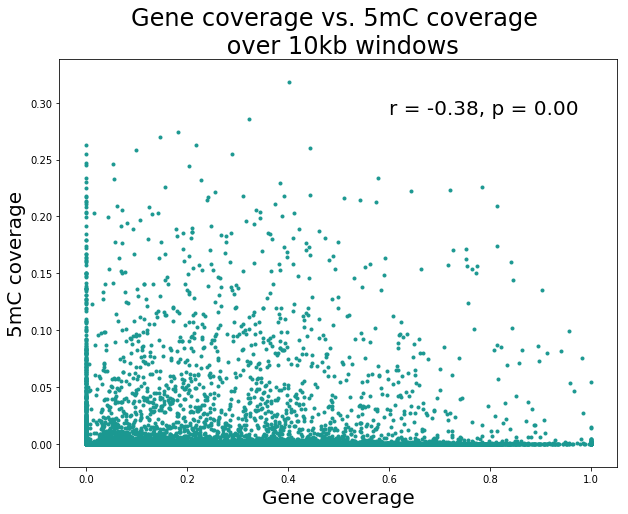

In [242]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(gene, m5c, marker='.', c='#1b9891')
plt.xlabel('Gene coverage', fontsize=20)
plt.ylabel('5mC coverage', fontsize=20)
plt.title("Gene coverage vs. 5mC coverage \n over 10kb windows", fontsize=24)
plt.text(0.6,0.29,'r = -0.38, p = 0.00', fontsize=20)
plt.show()

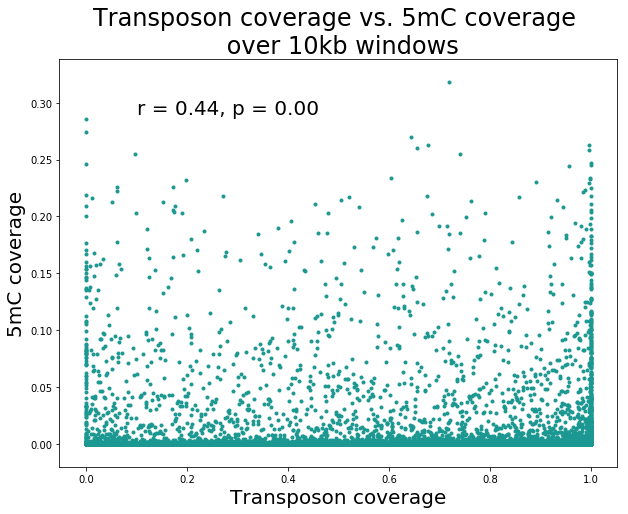

In [239]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(te, m5c, marker='.', c='#1b9891')
plt.xlabel('Transposon coverage', fontsize=20)
plt.ylabel('5mC coverage', fontsize=20)
plt.title("Transposon coverage vs. 5mC coverage \n over 10kb windows", fontsize=24)
plt.text(0.1,0.29,'r = 0.44, p = 0.00', fontsize=20)
plt.show()

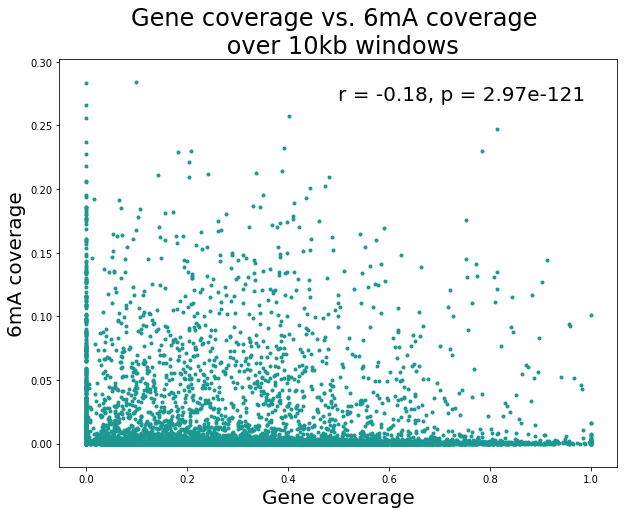

In [253]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(gene, m6a, marker='.', c='#1b9891')
plt.xlabel('Gene coverage', fontsize=20)
plt.ylabel('6mA coverage', fontsize=20)
plt.title("Gene coverage vs. 6mA coverage \n over 10kb windows", fontsize=24)
plt.text(0.5,0.27,'r = -0.18, p = 2.97e-121', fontsize=20)
plt.show()

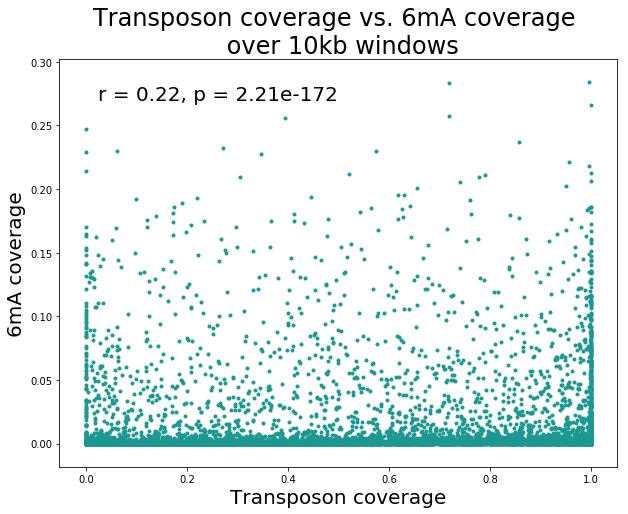

In [251]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(te, m6a, marker='.', c='#1b9891')
plt.xlabel('Transposon coverage', fontsize=20)
plt.ylabel('6mA coverage', fontsize=20)
plt.title("Transposon coverage vs. 6mA coverage \n over 10kb windows", fontsize=24)
plt.text(0.023,0.27,'r = 0.22, p = 2.21e-172', fontsize=20)
plt.show()

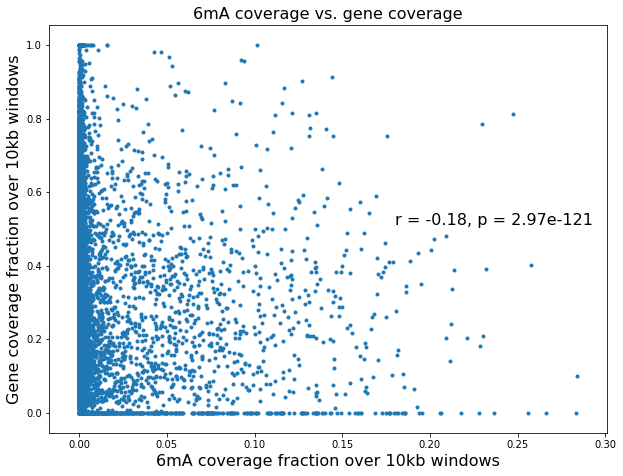

In [207]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(m6a, gene, marker='.')
plt.ylabel('Gene coverage fraction over 10kb windows', fontsize=16)
plt.xlabel('6mA coverage fraction over 10kb windows', fontsize=16)
plt.title("6mA coverage vs. gene coverage", fontsize=16)
plt.text(0.18,0.51,'r = -0.18, p = 2.97e-121', fontsize=16)
plt.show()

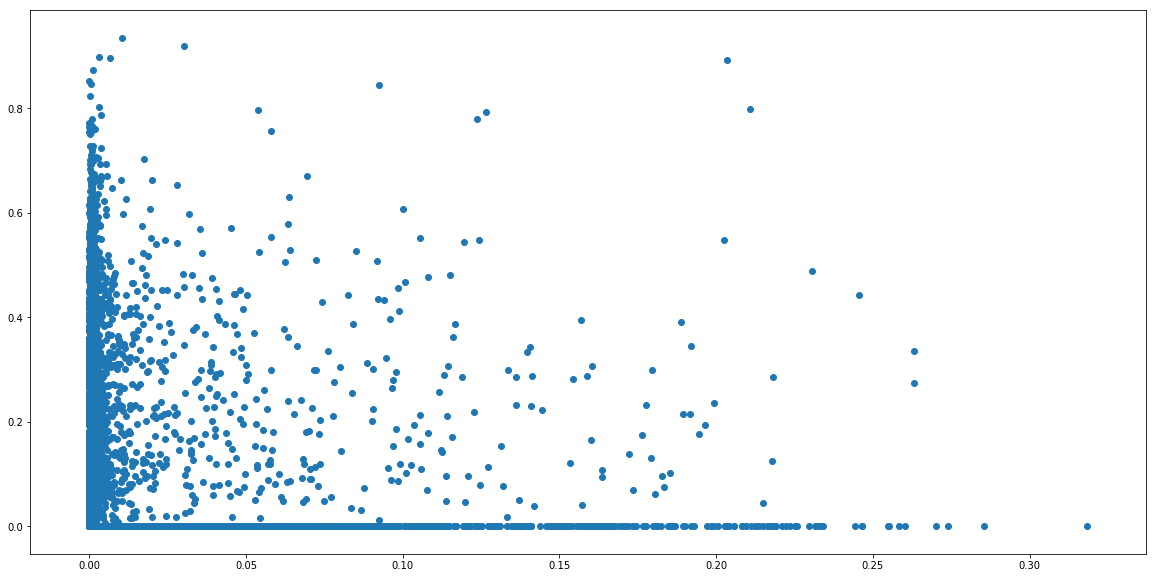

In [118]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(m5c, ltgene)
plt.show()

In [106]:
#scatterplots

#set data
m5c = coverage_fn_dict['5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed']['overlap_fraction']
m6a = coverage_fn_dict['6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed']['overlap_fraction']
gene = coverage_fn_dict['Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed']['overlap_fraction']
te = coverage_fn_dict['Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed']['overlap_fraction']
ltgene = coverage_fn_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed']['overlap_fraction']

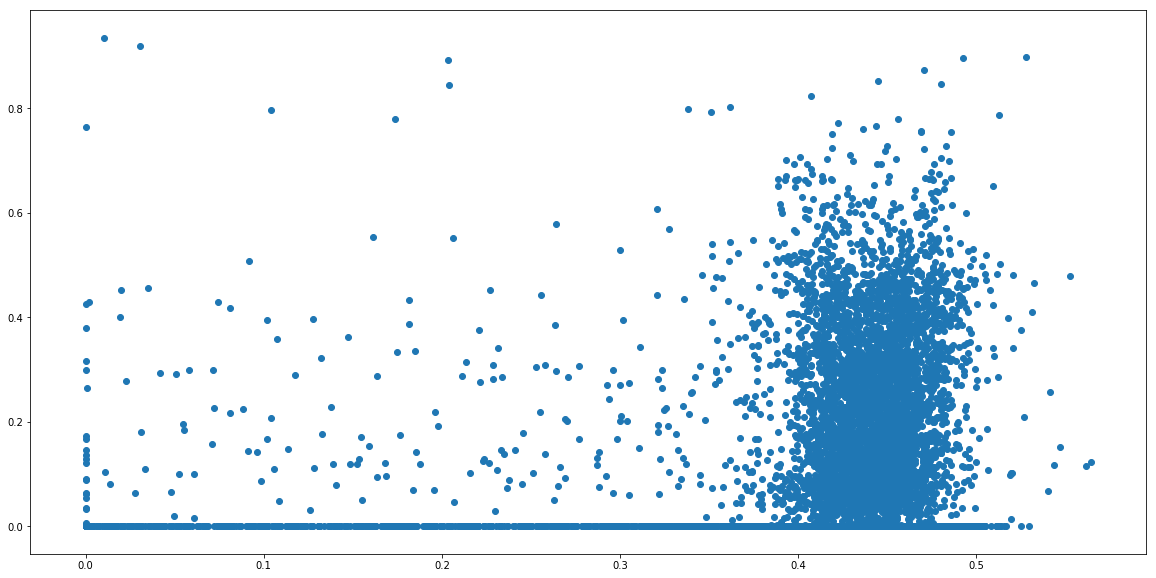

In [108]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(m5c, ltgene)
plt.show()

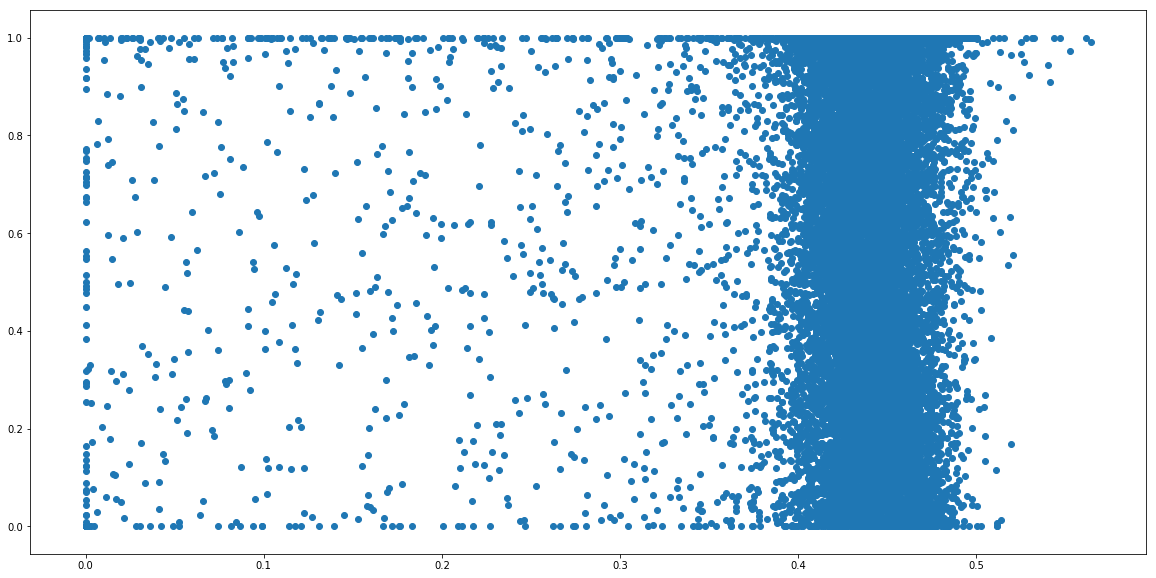

In [98]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(m5c, te)
plt.show()

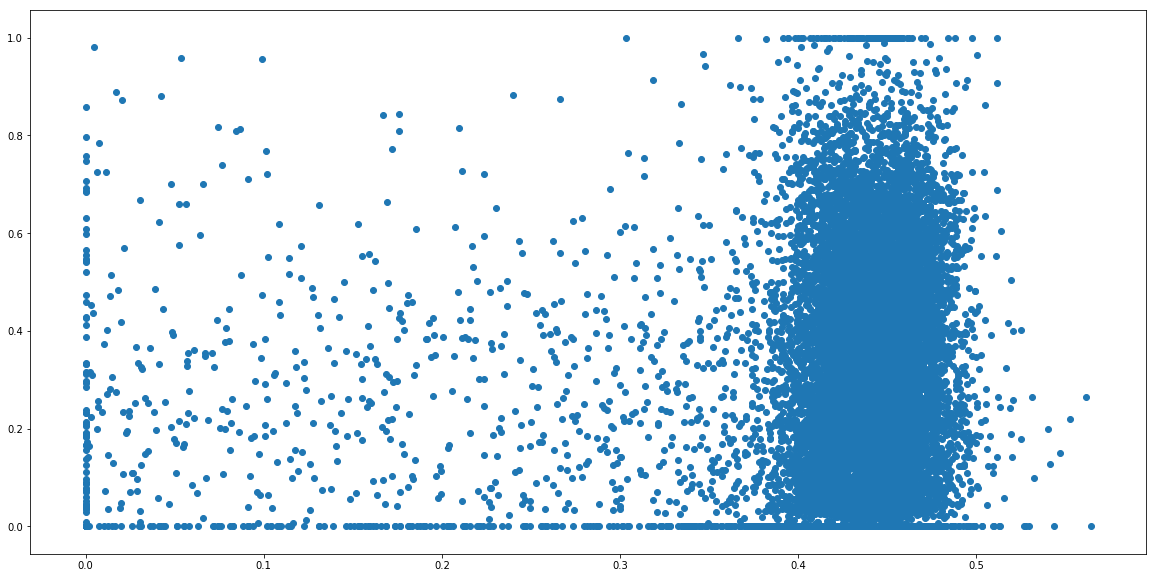

In [97]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(m5c, gene)
plt.show()

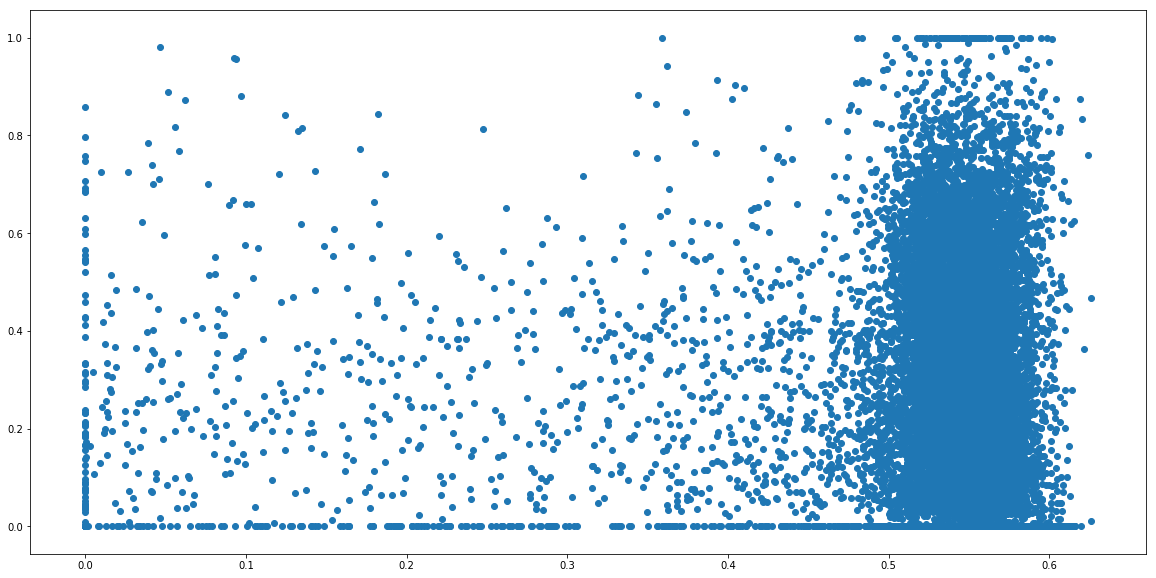

In [101]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.scatter(m6a, gene)
plt.show()

In [203]:
#scatterplots

#set data
m5c_h = gene_fraction_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed']['overlap_fraction']
m6a_h = gene_fraction_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed']['overlap_fraction']
ug_h = rnaseq_ug_sorted_dict['Pst_104E_v13_h_gene_rpkm_average.UG.sorted.tsv']['UG']
m5c_p = gene_fraction_dict['Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed']['overlap_fraction']
m6a_p = gene_fraction_dict['Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed']['overlap_fraction']
ug_p = rnaseq_ug_sorted_dict['Pst_104E_v13_p_gene_rpkm_average.UG.sorted.tsv']['UG']

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(m6a, gene, marker='.')
plt.ylabel('Gene expression (RPKM)', fontsize=16)
plt.xlabel('6mA coverage of gene', fontsize=16)
plt.title("6mA coverage vs. gene coverage", fontsize=16)
plt.text(0.18,0.51,'R = -0.18, p = 2.97e-121', fontsize=16)
plt.show()

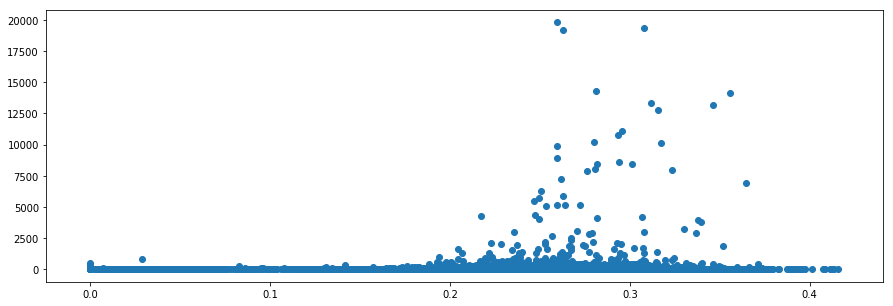

In [63]:
# still need to centre the title
fig, ax = plt.subplots(figsize=(15, 5))

plt.scatter(m5c_h, ug_h)#, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
plt.show()

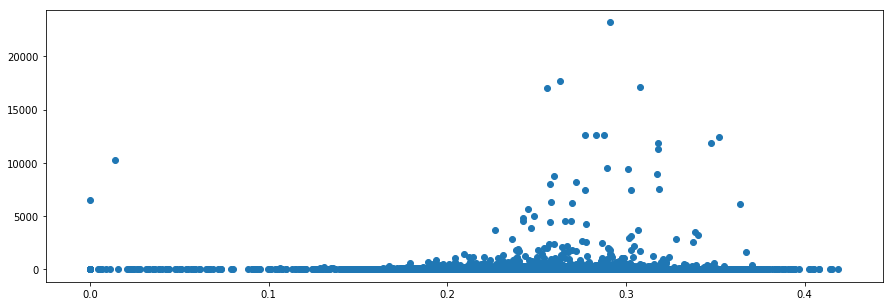

In [64]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(m5c_p, ug_p)
plt.show()

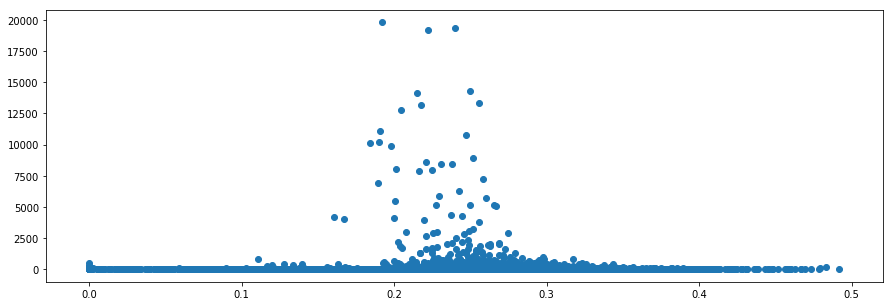

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.scatter(m6a_h, ug_h)#, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, hold=None, data=None, **kwargs)
plt.show()

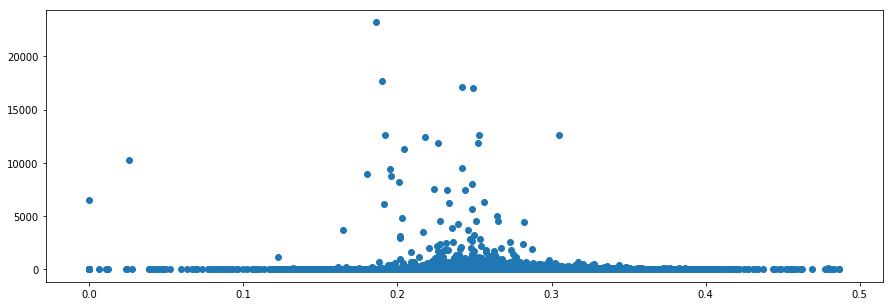

In [66]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(m6a_p, ug_p)
plt.show()

In [67]:
ug_spearman_dict

NameError: name 'ug_spearman_dict' is not defined

In [2505]:
# save out the Spearman's rho values as a table
spearman_df = pd.DataFrame.from_dict(ug_spearman_dict, orient='index')
spearman_df.rename(columns={0: 'R', 1: 'p-value'}, inplace=True)
out_fn = os.path.join(DIRS['FIGURES'], 'expression', 'spearman_r_table.tsv')
spearman_df.to_csv(out_fn, header=True, sep = '\t')

In [ ]:
# 6mA: Spearman's rho between ranked methylated genes in df and ranked expressed genes in df

In [ ]:
# Ignore both_u_d files for now!
# For the both_u_d files:
# iterrows through df and if name == name:
# add the frac1 + frac2 and divide by 2
# append the average to a list
# make a new df of ... ok this is too hard I'll ask Ben on Monday

In [ ]:
# Make files ranking genes expressed in each life cycle stage from high to low expression

# Make a new file of the highly expressed genes for each life cycle stage
# Make a new file of the lowly expressed genes for each life cycle stage

# Make a file of genes that are highly expressed in all stages -> for loop that checks whether gene is in all "highly expressed" files


## <span style='color:#9ac615'> 8. Intersecting methylation with transposons expression files. <span/>

## <span style='color:#ffa347'> 10. Comparing methylated transposons and genes. <span/>

## <span style='color:#ff4f14'> 11. Expression of methylation machinery throughout Pst life cycle. <span/>

DNMT1/MASC2
query: XP_001833175.2, len = 1253

h_subject: Pst104E_20230, len = 1248

Score = 206 bits (523), Expect = 5e-54, Method: Compositional matrix adjust. Identities = 241/925 (26%), Positives = 372/925 (40%), Gaps = 178/925 (19%)

p_subject: Pst104E_04293, len = 1248

Score = 206 bits (523), Expect = 5e-54, Method: Compositional matrix adjust. Identities = 241/925 (26%), Positives = 372/925 (40%), Gaps = 178/925 (19%)

RAD8
query: XP_001831325.2, len = 2184

h_subject: Pst104E_28179, len = 2204

Score = 1158 bits (2996), Expect = 0.0, Method: Compositional matrix adjust. Identities = 643/1386 (46%), Positives = 837/1386 (60%), Gaps = 76/1386 (5%)

p_subject: Pst104E_12497, len = 1248

DNMT1/MASC2
- h_subject: Pst104E_20230   //   gene_model_hcontig_0009_24.226
- p_subject: Pst104E_04293   //   gene_model_pcontig_009.363
    
RAD8
- h_subject: Pst104E_28179   //   gene_model_hcontig_0052_06.60
- p_subject: Pst104E_12497   //   gene_model_pcontig_052.64


In [ ]:
# write this function later!!
def grep_gene_name()

In [168]:
# make dicts of BLAST results
blast_h = { 'DNMT1/MASC2' : 'gene_model_hcontig_0009_24.226', 'RAD8' : 'gene_model_hcontig_0052_06.60' }
blast_p = { 'DNMT1/MASC2' : 'gene_model_pcontig_009.363', 'RAD8' : 'gene_model_pcontig_052.64' }

In [169]:
# make rnaseq dict
rnaseq_df_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_average.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 87:
        df = pd.read_csv(fn, header=0, sep='\t')
        rnaseq_df_dict[fn.split('/')[-1]] = df

In [180]:
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_average.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 87:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [181]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_rpkm_average.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_average.tsv',
 'Pst_104E_v13_p_gene_rpkm_average.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_average.tsv'}

In [166]:
DIRS['MEAN_STD']

'/home/anjuni/analysis/rna_counts/average_and_stdev'

In [171]:
rnaseq_df_dict['Pst_104E_v13_h_gene_rpkm_average.tsv'].head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [172]:
for rkey, rvalue in rnaseq_fn.items():
    df = pd.read_csv(rvalue, sep='\t', header = 0)

df.head()
type(df)

pandas.core.frame.DataFrame

In [173]:
def blast_exp_df(blast_dict, rnaseq_df):
    for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_

SyntaxError: invalid syntax (<ipython-input-173-bc07e9909af0>, line 3)

In [189]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_hcontig_0009_24.226
GS                                14.0442
HE                                 10.199
IT0                                     0
IT6                               8.27879
IT9                               13.4791
UG                                8.75372
Name: 5163, dtype: object
gene_ID    gene_model_hcontig_0052_06.60
GS                               25.5531
HE                               5.27593
IT0                              4.24689
IT6                              23.0232
IT9                              43.3039
UG                               23.2504
Name: 14740, dtype: object


In [2554]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS                             12.535
HE                            9.15761
IT0                                 0
IT6                           7.68013
IT9                           12.3386
UG                            7.73364
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS                           22.8899
HE                           4.73403
IT0                          3.78453
IT6                          21.4138
IT9                          39.8084
UG                           20.6473
Name: 15076, dtype: object


In [199]:
blast_dict = blast_h
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_h_gene_rpkm_average.tsv'] = rnaseq_fn_dict['Pst_104E_v13_h_gene_rpkm_average.tsv']

In [ ]:
# getting stdev

In [194]:
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_stdev.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 85:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [195]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_rpkm_stdev.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_stdev.tsv',
 'Pst_104E_v13_p_gene_rpkm_stdev.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_stdev.tsv'}

In [200]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_hcontig_0009_24.226
GS                               0.710032
HE                               0.244654
IT0                                     0
IT6                               1.12791
IT9                               1.75511
UG                                1.15206
Name: 5163, dtype: object
gene_ID    gene_model_hcontig_0052_06.60
GS                               2.11856
HE                              0.382341
IT0                              6.00601
IT6                              2.55504
IT9                              11.9945
UG                              0.954619
Name: 14740, dtype: object


In [201]:
blast_dict = blast_p
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_p_gene_rpkm_average.tsv'] = rnaseq_fn_dict['Pst_104E_v13_p_gene_rpkm_average.tsv']

In [184]:
rnaseq_fn

{'Pst_104E_v13_h_gene_rpkm_average.tsv':                                    gene_ID          GS          HE        IT0  \
 0             gene_model_hcontig_0000_03.1    0.487427    0.000000   0.000000   
 1             gene_model_hcontig_0000_03.2    0.577405  144.208849   0.000000   
 2             gene_model_hcontig_0000_03.3  564.783136   52.086774  24.713948   
 3             gene_model_hcontig_0000_03.4    0.000000    0.167865   0.000000   
 4       EVM prediction%2hcontig_0000_003.5    0.000000    0.000000   0.000000   
 5       EVM prediction%2hcontig_0000_003.6    0.000000    0.000000   0.000000   
 6             gene_model_hcontig_0000_03.7   10.457924    0.176728   0.000000   
 7             gene_model_hcontig_0000_03.8    0.000000   31.659461   0.000000   
 8             gene_model_hcontig_0000_03.9    0.005005    0.000000   0.000000   
 9            gene_model_hcontig_0000_03.10    0.000000    0.000000   0.000000   
 10           gene_model_hcontig_0000_03.11    0.035380   

In [202]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS                           0.626692
HE                           0.208539
IT0                                 0
IT6                           1.11119
IT9                            1.5958
UG                            1.02412
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS                           1.90044
HE                           0.33067
IT0                          5.35214
IT6                          2.06825
IT9                          11.0626
UG                          0.833817
Name: 15076, dtype: object


In [218]:
# getting all values
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_repRpkmMatrix_featureCounts.tsv' % DIRS['TRIALS'], recursive=True):
    if len(fn) == 95:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [219]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv': '/home/anjuni/analysis/rna_counts/trials_tsv/Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv',
 'Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv': '/home/anjuni/analysis/rna_counts/trials_tsv/Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv'}

In [220]:
blast_dict = blast_h
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv'] = rnaseq_fn_dict['Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv']

In [222]:
blast_dict = blast_p
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv'] = rnaseq_fn_dict['Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv']

In [223]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS_1                          13.4194
GS_2                          12.0437
GS_3                          12.1418
HE_1                          9.45151
HE_2                          9.03185
HE_3                          8.98946
IT0_1                               0
IT0_2                               0
IT0_3                               0
IT6_1                         8.02585
IT6_2                         8.83485
IT6_3                          6.1797
IT9_1                         10.5812
IT9_2                          11.991
IT9_3                         14.4435
UG_1                          8.34558
UG_2                          6.29084
UG_3                          8.56451
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS_1                         24.0007
GS_2                          20.215
GS_3                         24.4539
HE_1                         4.28587
HE_2                         5.07378
HE_3                         4

In [ ]:
# pull out the gene names for these locus tags from the annotation files

# test for significant difference between alleles on both contigs

## <span style='color:#ff4f14'>  12. Data processing for tables and graphs. <span/>

In [ ]:
# Make cutoff files for Nanopolish and SMRTLink, for the table

# Saving out a csv file of cutoff vs. num_sites_file1, num_sites_file2, num_overlap_sites, %_overlap for each initial file
# Already done for tombo 6mA and all overlaps, need to do for NP, Tombo CpG and PB cutoff files
# The csv will be formatted in excel :)

# Ask Ben how to format headings properly

header_6mA = ['Cutoff', 'Nanopore', 'PacBio', 'Overlapping sites', 'Percentage Overlap']

header_5mC = ['Cutoff', 'Tombo', 'Nanopolish', 'Overlapping sites', 'Percentage Overlap']

for akey, avalue in dict_a.items():
    for bkey, bvalue in dict_b.items():
        linakey= []
        if akey == bkey:
            cutoff = akey[x:x]
            line.append(cutoff, avalue, bvalue)
            